In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38977")
client

<Client: 'tcp://127.0.0.1:38977' processes=8 threads=40, memory=157.35 GiB>

Task exception was never retrieved
future: <Task finished name='Task-234090' coro=<Client._gather.<locals>.wait() done, defined at /tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-235024' coro=<Client._gather.<locals>.wait() done, defined at /tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-235022' coro=<Client._gather.<loc

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import xrft
import gsw
import pandas
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from fastjmd95 import drhods, drhodt
# import MITgcmutils as mitutils
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
%matplotlib inline

In [3]:
# Physical coefficients 
grav = 9.81
rho0 = 999.8
Cp = 3.994e3
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20

# Domain selection 
ychunk = 450
xchunk = 250
ystart = -15
yend = 50


In [4]:
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir_old = '/tank/topog/lsun/modewater/' # Saves cs_snap and maximum_cs
savedir = '/tank/spectre/lsun/modewater/' 
bdir = 'bcoor/'
twadir = 'TWA/'
figdir = '/tank/users/lsun/figures/modewater/' # Directory for figures

In [5]:

# Time set-up
years = np.arange(1967,1968,dtype=int)
dnf = 2160 #time interval
nfile = 73 #time steps in a year
ini_time = 1419120
fin_time = 1574640
ntimes = np.arange(ini_time,fin_time+dnf,dnf).reshape(len(years),nfile)
dates = pandas.date_range(start='1967-01-03',end='1967-12-29',periods=73)

# Ensemble members 
membs = np.arange(100,148,dtype=int)
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'

## Compute MLD for all members

In [6]:
yy = 0 

XC_range = [280, 340]
YC_range = [20, 45.1]
drho_thres = 0.01
dtheta_thres = 0.2

for year in years:
    for itime in ntimes[yy]:
        
        for nmemb in membs:
            ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (nmemb,year)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn'], 
                                     delta_t=2e2, iters=itime,
                                     # chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                          YG=slice(ystart-12**-1,yend+2*12**-1)
                                         ).chunk({'XC':xchunk,'XG':xchunk,
                                                  'YC':ychunk,'YG':ychunk})

            grid = Grid(ds, periodic=['X'])
            
            theta = ds.THETA.where(ds.maskC!=0.)
            salt = ds.SALT.where(ds.maskC!=0.)
            # pres = rho0*grav*(-ds.Z) * 1e-4
            
            # Derivatives of in-situ densities 
            rho = xr.apply_ufunc(densjmd95, salt, theta, 0,           
                                        dask='parallelized', output_dtypes=[float,]
                                       ).where(ds.maskC!=0.)
            
            drho = (rho.sel(YC = slice(YC_range[0],YC_range[1]), 
                           XC = slice(XC_range[0],XC_range[1]))
                 - rho.isel(Z=1).sel(YC = slice(YC_range[0],YC_range[1]), 
                           XC = slice(XC_range[0],XC_range[1]))
                   ) #choose layer ~10m in depth
            if nmemb == membs[0]:
                MLD_membs = ds.Z.where(np.abs(drho)>drho_thres).max('Z')
            else:
                MLD_membs = xr.concat([MLD_membs, 
                                       ds.Z.where(np.abs(drho)>drho_thres).max('Z')], 'imemb')
            
            # # use temperature as a threshold
            # dtheta = (theta.sel(YC = slice(YC_range[0],YC_range[1]), 
            #                XC = slice(XC_range[0],XC_range[1]))
            #      - theta.isel(Z=0).sel(YC = slice(YC_range[0],YC_range[1]), 
            #                XC = slice(XC_range[0],XC_range[1]))
            #        ) 
            # if nmemb == membs[0]:
            #     MLD_membs = ds.Z.where(np.abs(dtheta)>dtheta_thres).max('Z')
            # else:
            #     MLD_membs = xr.concat([MLD_membs, 
            #                            ds.Z.where(np.abs(drho)>drho_thres).max('Z')], 'imemb')
        print(itime)
        dsave = MLD_membs.to_dataset(name='MLD').chunk({'YC':ychunk, 'XC':xchunk})   
        dsave.to_zarr(op.join(savedir,twadir,'run%4d/MLD01/%010d/' 
                                            % (year,itime)), mode='w')

/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 46.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 18.48 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 46.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 18.48 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  war

1419120


KeyboardInterrupt: 

## Determine mask for mixed layer 

In [6]:
year = 1967

XC_range = [279.5, 340]
YC_range = [20, 45.1]
theta_quantile = 0.25 # negative values for mld so 0 quantile means all values are considered.
    
for itime in ntimes[0,32:]:
    ds_mld = xr.open_zarr(op.join(savedir,twadir,'run%4d/MLD/%010d/' 
                                            % (year,itime))
                             )
    for imemb in membs:
        ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (imemb,year)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn'], 
                                     delta_t=2e2, iters=itime,
                                     chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                          YG=slice(ystart-12**-1,yend+2*12**-1))

        dsz = xr.open_zarr(op.join(savedir,bdir,'Zs/run%4d/memb%02d/%010d/' 
                                   % (year,imemb,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               ).reset_coords(drop=True)

        zeta_tmp = (dsz.zdz * dsz.dzetaF**-1).sel(YC = slice(YC_range[0],YC_range[1]), 
                           XC = slice(XC_range[0],XC_range[1]))
        
        
        # depth under the mixed layer in TWA
        if imemb == membs[0]:
            zeta = zeta_tmp
        else:
            zeta = xr.concat([zeta, 
                              zeta_tmp], 'imemb')
            
    zeta_mask = zeta.where(zeta <= ds_mld.MLD.chunk({'imemb':-1}
                                                       ).quantile(theta_quantile, 
                                                                  dim = 'imemb')
                              ).mean('imemb')
    dsave = zeta_mask.to_dataset(name='mask').chunk({'YC':ychunk, 'XC':xchunk})   
    dsave.to_zarr(op.join(savedir,twadir,'run%4d/Zeta_mask_75/%010d/' 
                                        % (year,itime)), mode='w')
    print(itime)


1488240
1490400
1492560
1494720
1496880
1499040
1501200
1503360
1505520
1507680
1509840
1512000
1514160
1516320
1518480
1520640
1522800
1524960
1527120
1529280
1531440
1533600
1535760
1537920
1540080
1542240
1544400
1546560
1548720
1550880
1553040
1555200
1557360
1559520
1561680
1563840
1566000
1568160
1570320
1572480
1574640


## Plots

Ensemble-mean of temperature in depth with threshold of mixed layer depth of all members. 

In [37]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [8]:
year = 1967
XC_range = [279.5, 340]
YC_range = [20, 45.1]

for itime in ntimes[0]:
    
    for imemb in membs:
        ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (imemb,year)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn'], 
                                     delta_t=2e2, iters=itime,
                                     chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                          YG=slice(ystart-12**-1,yend+2*12**-1))
        if imemb == membs[0]:
            theta_tmp = ds.THETA.where(ds.maskC !=0).sel(YC = slice(YC_range[0],YC_range[1]), 
                            XC = slice(XC_range[0],XC_range[1]))
        else:
            theta_tmp = xr.concat([theta_tmp, 
                              ds.THETA.where(ds.maskC !=0).sel(YC = slice(YC_range[0],YC_range[1]), 
                                XC = slice(XC_range[0],XC_range[1]))
                              ], 'imemb')

    if itime == ntimes[0,0]:
        mld_mask_75 = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zeta_mask_75/%010d/' 
                                        % (year,itime))
                  )
        theta = theta_tmp.mean('imemb')
    else:
        mld_mask_75 = xr.concat([mld_mask_75, xr.open_zarr(op.join(savedir,twadir,'run%4d/Zeta_mask_75/%010d/' 
                                        % (year,itime))
                                                          )], 'time')
        theta = xr.concat([theta, theta_tmp.mean('imemb')], 'time')
        

        
           

In [111]:
theta_winter = theta.isel(time = 6
                         ).sel(XC = 295, method = 'nearest'
                              ).sel(Z = slice(None,-700), 
                                    YC = slice(20, 40)
                                                     ) # Feb 02
theta_summer = theta.isel(time = 42
                         ).sel(XC = 295, method = 'nearest'
                              ).sel(Z = slice(None,-700), 
                                    YC = slice(20, 40)
                                                     ) # Aug 01
theta_surface = theta.mean('time').isel(Z = 0).sel(YC = slice(20, 40)
                                                  )

mld_winter = mld_mask_75.sel(XC = 295, method = 'nearest'
                            ).sel(YC = slice(20, 40)
                                                  ).isel(time = 6
                                  ).max('delta_outer')

mld_summer = mld_mask_75.sel(XC = 295, method = 'nearest'
                            ).sel(YC = slice(20, 40)
                                                  ).isel(time = 42
                                  ).max('delta_outer')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


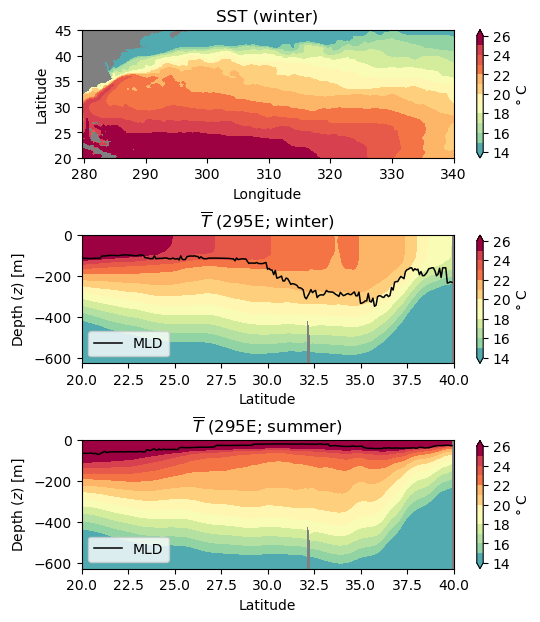

In [127]:
# cmap = plt.get_cmap('viridis', 20)
# cmap = truncate_colormap(cmap, 0.1, 1)
cmap = plt.get_cmap('Spectral_r', 20)
cmap = truncate_colormap(cmap, 0.15, 1)


fig, ax = plt.subplots(figsize = (6,7), nrows = 3)
plt.subplots_adjust(hspace=0.6)

im0 = ax[0].contourf(theta.isel(Z=0, time = 6).XC,
                     theta.isel(Z=0, time = 6).YC,
                     theta.isel(Z=0, time = 6), 
                     cmap=cmap, 
                    extend='both', levels=np.linspace(14,26,13)
                    )  
fig.colorbar(im0, label = '$\degree$ C')

ax[0].set_title('SST (winter)')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_facecolor('grey')
ax[0].set_xticks(range(280,341,10))
ax[0].set_yticks(range(20,46,5))

im1 = ax[1].contourf(theta_winter.YC, 
                     theta_winter.Z, 
                     theta_winter, 
                     levels=np.linspace(14,26,13),
                     extend='both', cmap=cmap
                    )  
ax[1].plot(mld_winter.mask.YC, mld_winter.mask, 
           color='k', linewidth = 1.1, label = 'MLD')

fig.colorbar(im1, label = '$\degree$ C')

ax[1].set_title('$\overline{T}$ (295E; winter)')
ax[1].set_xlabel('Latitude')
ax[1].set_ylabel('Depth ($z$) [m]')
ax[1].set_facecolor('grey')
ax[1].set_xlim([20,40])
ax[1].set_yticks(range(-600,1,200))
ax[1].legend(loc = 'lower left')

im2 = ax[2].contourf(theta_summer.YC, 
                     theta_summer.Z, 
                     theta_summer, 
                     levels=np.linspace(14,26,13),
                     extend='both', cmap=cmap
                    )  
ax[2].plot(mld_summer.mask.YC, mld_summer.mask, 
           color='k', linewidth = 1.1, label = 'MLD')

fig.colorbar(im2, label = '$\degree$ C')

ax[2].set_title('$\overline{T}$ (295E; summer)')
ax[2].set_xlabel('Latitude')
ax[2].set_ylabel('Depth ($z$) [m]')
ax[2].set_yticks(range(-600,1,200))
ax[2].set_facecolor('grey')
ax[2].set_xlim([20,40])
ax[2].legend(loc = 'lower left')

plt.savefig(figdir+'temperature_MLD_1967.eps', format = 'eps', dpi= 600, 
              bbox_inches = 'tight', pad_inches = 0.1)

In [29]:
dst = xr.open_zarr(op.join(savedir,bdir,'Tracers/run%4d/memb%02d/%010d/' 
                                  % (year,imemb,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            
                               ).reset_coords(drop=True)
dst


<xarray.Dataset>
Dimensions:      (time: 1, YC: 783, XC: 1000, delta_outer: 55, delta: 54)
Coordinates:
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.92 50.0 50.08
  * delta        (delta) float64 20.32 20.93 21.45 21.9 ... 28.78 28.94 29.11
  * delta_outer  (delta_outer) float64 19.98 20.65 21.21 ... 28.86 29.03 29.2
  * time         (time) timedelta64[ns] 3465 days
Data variables:
    Sdz          (time, YC, XC, delta_outer) float32 dask.array<chunksize=(1, 450, 250, 55), meta=np.ndarray>
    Tdz          (time, YC, XC, delta_outer) float32 dask.array<chunksize=(1, 450, 250, 55), meta=np.ndarray>

In [ ]:
theta_mean = ds.THETA.mean('imemb').sel(YC = slice(YC_range[0],YC_range[1]), 
                           XC = slice(XC_range[0],XC_range[1]))

In [ ]:
ds.THETA

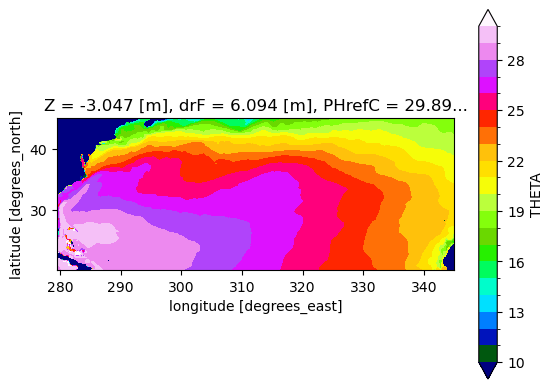

In [126]:
fig, ax = plt.subplots()
theta_mean.isel(Z=0,time=36).plot.contourf(ax=ax, levels=np.linspace(10,30,21), 
                                          extend='both', cmap='gist_ncar')
ax.set_aspect('equal')

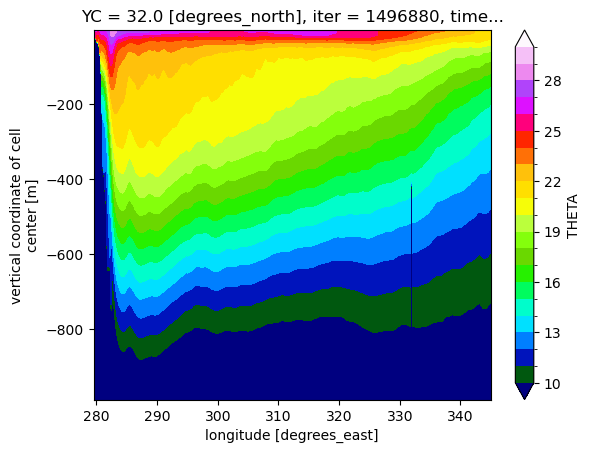

In [128]:
fig, ax = plt.subplots()
theta_mean.isel(time=36).sel(YC=32,method='nearest'
                           ).sel(Z=slice(None,-1000)).plot.contourf(ax=ax, levels=np.linspace(10,30,21), 
                                          extend='both', cmap='gist_ncar')

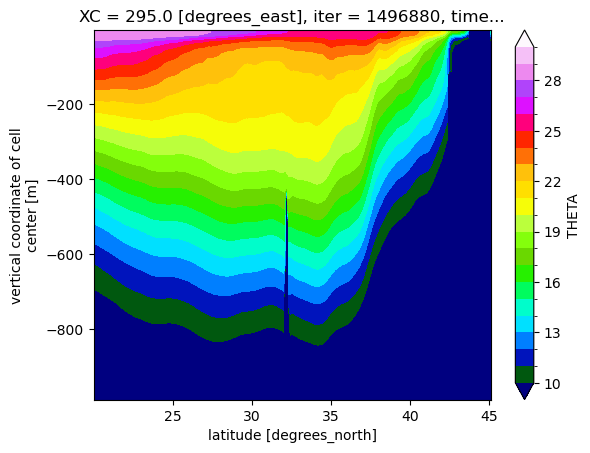

In [129]:
fig, ax = plt.subplots()
theta_mean.isel(time=36).sel(XC=295,method='nearest'
                           ).sel(Z=slice(None,-1000)).plot.contourf(ax=ax, levels=np.linspace(10,30,21), 
                                          extend='both', cmap='gist_ncar')

In [90]:
year = 1967

XC_range = [279.5, 345]
YC_range = [20, 45.1]
    
for imemb in membs:
    if imemb == membs[0]:
        ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (imemb,year)), 
                                         grid_dir=gdir,
                                         prefix=['snap_diagOcn'], 
                                         delta_t=2e2, iters=ntimes[0],
                                         
                                        ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                              YG=slice(ystart-12**-1,yend+2*12**-1)
                                             ).chunk({'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk})
            
    else:
        ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (imemb,year)), 
                                         grid_dir=gdir,
                                         prefix=['snap_diagOcn'], 
                                         delta_t=2e2, iters=ntimes[0],
                                        ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                              YG=slice(ystart-12**-1,yend+2*12**-1)
                                             ).chunk({'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk})
                           ], 'imemb')
ds

/tank/users/lsun/.conda/envs/modewater/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/users/lsun/.conda/envs/modewater/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/users/lsun/.conda/envs/modewater/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/users/lsun/.conda/envs/modewater/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
Task exception was never retrieved
futur

<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 783, XG: 1000, YG: 783, Z: 46, Zp1: 47, Zu: 46,
              Zl: 46, time: 73, imemb: 48)
Coordinates: (12/33)
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -15.04 -14.96 -14.87 -14.79 ... 49.88 49.96 50.04 50.13
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
  * Zp1      (Zp1) >f4 0.0 -6.094 -12.81 -19.91 ... -5.5e+03 -5.75e+03 -6e+03
    ...       ...
    maskInC  (YC, XC) bool dask.array<chunksize=(450, 250), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(450, 250), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(450, 250), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3285 days 3290 days ... 3640 days 3645 days
Dimensions without coordinates: imemb
Data variables:
    THETA    (imemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 450, 250), meta=np.ndarray>
    SALT     (imemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 450, 250), meta=np.ndarray>
    UVEL     (imemb, time, Z, YC, XG) float32 dask.array<chunksize=(1, 1, 46, 450, 250), meta=np.ndarray>
    VVEL     (imemb, time, Z, YG, XC) float32 dask.array<chunksize=(1, 1, 46, 450, 250), meta=np.ndarray>
    WVEL     (imemb, time, Zl, YC, XC) float32 dask.array<chunksize=(1, 1, 46, 450, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

KeyboardInterrupt: 

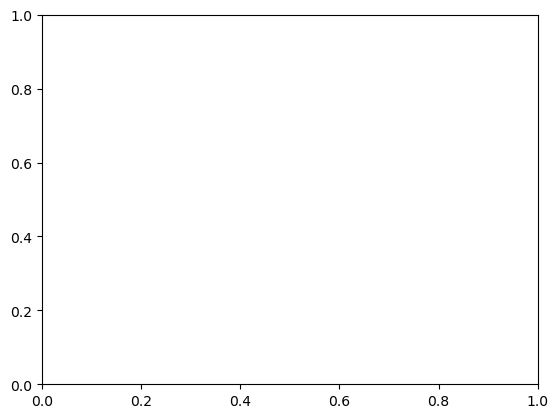

In [115]:
fig, ax = plt.subplots()
ds.THETA.sel(XC=360-65,method='nearest'
                          ).sel(YC=slice(25,40), Z=slice(None,-1000)).mean(['imemb','time']).plot.contourf(ax=ax, 
                                                                        levels=np.linspace(10,26,33), 
                                          extend='both', cmap='gist_ncar')

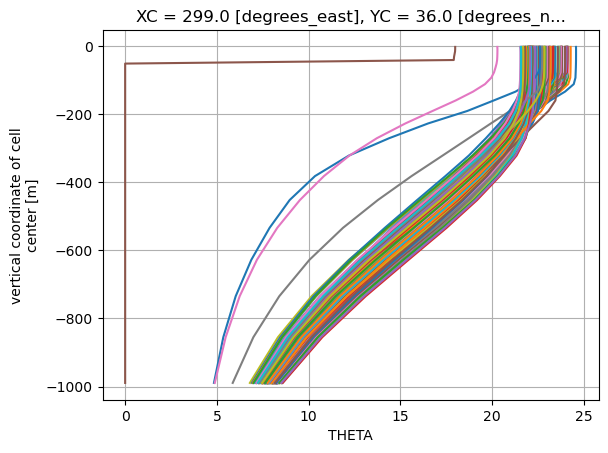

In [116]:
fig, ax = plt.subplots()
for i in range(27,37):
    for j in range(285,300):
        ds.THETA.sel(YC=i, method='nearest'
               ).sel(XC=j, method='nearest'
               ).sel(Z=slice(None,-1e3)).mean('imemb').isel(time = 6).plot(ax=ax,
                                                                             y='Z')
# ds.THETA.sel(YC=30,method='nearest'
#             ).sel(XC=360-65, method='nearest'
#                  ).sel(Z=slice(None,-1e3)).mean('imemb').isel(time = 30).plot(ax=ax,
#                                                                               y='Z',color='k',label='Jun 02')

ax.grid(True)
# ax.legend()